In [1]:
import sys
sys.path.append('..')
from utils import load_iterable_dataset
from transformer_lens import HookedTransformer
import torch as t
from tqdm import tqdm

In [2]:
DTYPE = t.bfloat16
MODEL_NAME = "pythia-70m"
ctx_len = 1024

In [3]:
# data = load_iterable_dataset('roneneldan/TinyStories')
data = load_iterable_dataset('monology/pile-uncopyrighted', streaming=True)

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
model = HookedTransformer.from_pretrained(MODEL_NAME, device='cuda', dtype=DTYPE)

Loaded pretrained model pythia-70m into HookedTransformer


In [5]:
def get_losses_per_pos(n_batches=10, prepend_bos=False, batch_size=32):
    losses = []
    for i in tqdm(range(n_batches)):
        batch = []
        for _ in range(batch_size):
            found=False
            while not found:
                text = next(data)
                tokens = model.to_tokens([text], prepend_bos=False)
                if tokens.shape[1] >= ctx_len:
                    batch.append(text)
                    found=True

        tokens = model.to_tokens(batch, prepend_bos=prepend_bos)[:, :ctx_len]
    
        with t.no_grad():
            loss = model(
                tokens, 
                return_type="loss",
                loss_per_token=True
            )
        losses.append(loss)
    return t.cat(losses).mean(0)

In [6]:
t.cuda.empty_cache()
loss_nobos = get_losses_per_pos(n_batches=10, prepend_bos=False)
loss_bos = get_losses_per_pos(n_batches=10, prepend_bos=True)

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


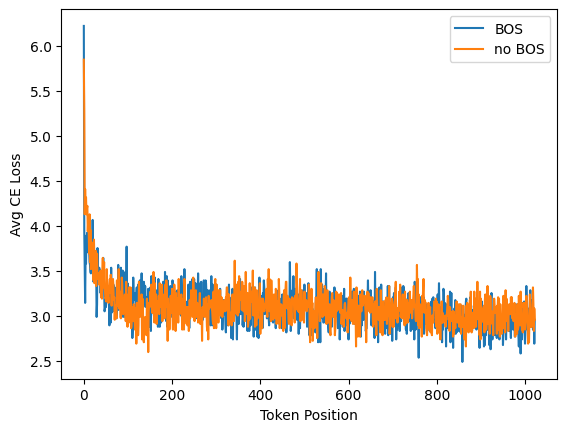

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss_bos.float().cpu().numpy())
plt.plot(loss_nobos.float().cpu().numpy())
# axis labels
plt.xlabel('Token Position')
plt.ylabel('Avg CE Loss')
# legend
plt.legend(['BOS', 'no BOS'])

In [8]:
loss_nobos[:].mean(), loss_bos[:].mean()

(tensor(3.1094, device='cuda:0', dtype=torch.bfloat16),
 tensor(3.0938, device='cuda:0', dtype=torch.bfloat16))